In [1]:
library(tidyverse)
library(BayesianTools)
library(binom)
library(plyr)
library(deSolve)
library(coda)
library(lubridate)
theme_set(theme_minimal())

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.7     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object i

In [26]:
data <- read.csv("https://raw.githubusercontent.com/Stijn-A/RSV_serology/master/data/infection_status_csv.txt",
                 sep=",")
# use if offline
#library(readr)
#data <- read_csv("LSHTM/Project/Data/infection_status.csv")

# Group age into intervals 
# bi-monthly for 0-2 years and 6-monthly for 2-5 years
data$agegrp <- cut(data$age_days,
                   breaks=c(seq(0,730, by=30.41*2),
                            seq(909,2000, by=30.41*6)), 
                   include.lowest = T, right=F)
# Divide by season of birth
spring <- c(3, 4, 5)
summer <- c(6, 7, 8)
autumn <- c (9, 10, 11)
winter <- c(1, 2, 12)

data <- data %>%
  mutate(
    Birth_mo = birthday %>% month()
  )%>%
  mutate(
    season_birth = case_when(
      Birth_mo %in% spring ~ "Spring",
      Birth_mo %in% summer ~ "Summer",
      Birth_mo %in% autumn ~ "Autumn",
      Birth_mo %in% winter ~ "Winter")
  )%>%
  mutate(
      visitnursery_child = case_when(
          visitnursery_child == 1 ~ "Yes",
          visitnursery_child == 0 ~ "No")
      )

In [27]:
head(data)

,age_days,birthday,consultdate,infection,IgG_PreF,IgA_PreF,IgG_PostF,IgA_PostF,IgG_Ga,IgA_Ga,⋯,visitnursery_child,visitnursery_house,pregnancytime,contacttotal,contact04,contact59,sex,agegrp,Birth_mo,season_birth
,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<chr>
1,676,2004-04-01,2006-02-06,1,0.3565,0.60,9.3264,0.08,0.260000,0.01,⋯,No,0,NA,3,1,0,2,"[669,730)",4,Spring
2,600,2004-07-23,2006-03-15,1,772.3431,33.15,473.5323,14.52,3.130699,0.02,⋯,Yes,0,NA,29,20,0,1,"[547,608)",7,Summer
3,588,2004-08-09,2006-03-20,0,0.1800,0.03,0.2100,0.19,0.580000,0.03,⋯,No,0,NA,4,1,0,2,"[547,608)",8,Summer
4,591,2004-08-06,2006-03-20,1,740.2907,70.38,466.2055,49.78,1.886910,0.05,⋯,No,0,NA,2,0,0,2,"[547,608)",8,Summer
5,1184,2002-12-29,2006-03-27,1,1999.2353,NA,1459.5921,NA,55.896003,NA,⋯,No,0,NA,6,2,3,1,"[1.09e+03,1.27e+03)",12,Winter
6,686,2004-05-12,2006-03-29,1,807.2200,NA,838.7400,NA,15.000000,NA,⋯,No,0,NA,2,0,0,2,"[669,730)",5,Spring


In [28]:
nusrey <- data %>% dplyr::group_by(agegrp, visitnursery_child) %>% 
  dplyr::summarise(agemid=round(median(age_days)), # Age midpoint in age group
                   N=n(), # Total N in age group
                   nconv=sum(infection))

`summarise()` has grouped output by 'agegrp'. You can override using the `.groups` argument.


In [29]:
nusrey <- subset(nusrey, !is.na(visitnursery_child))

In [30]:
nusrey[,c("seroprev_mean","seroprev_low95","seroprev_up95")] <- binom.confint(nusrey$nconv, nusrey$N, method="exact")[,c("mean","lower","upper")]

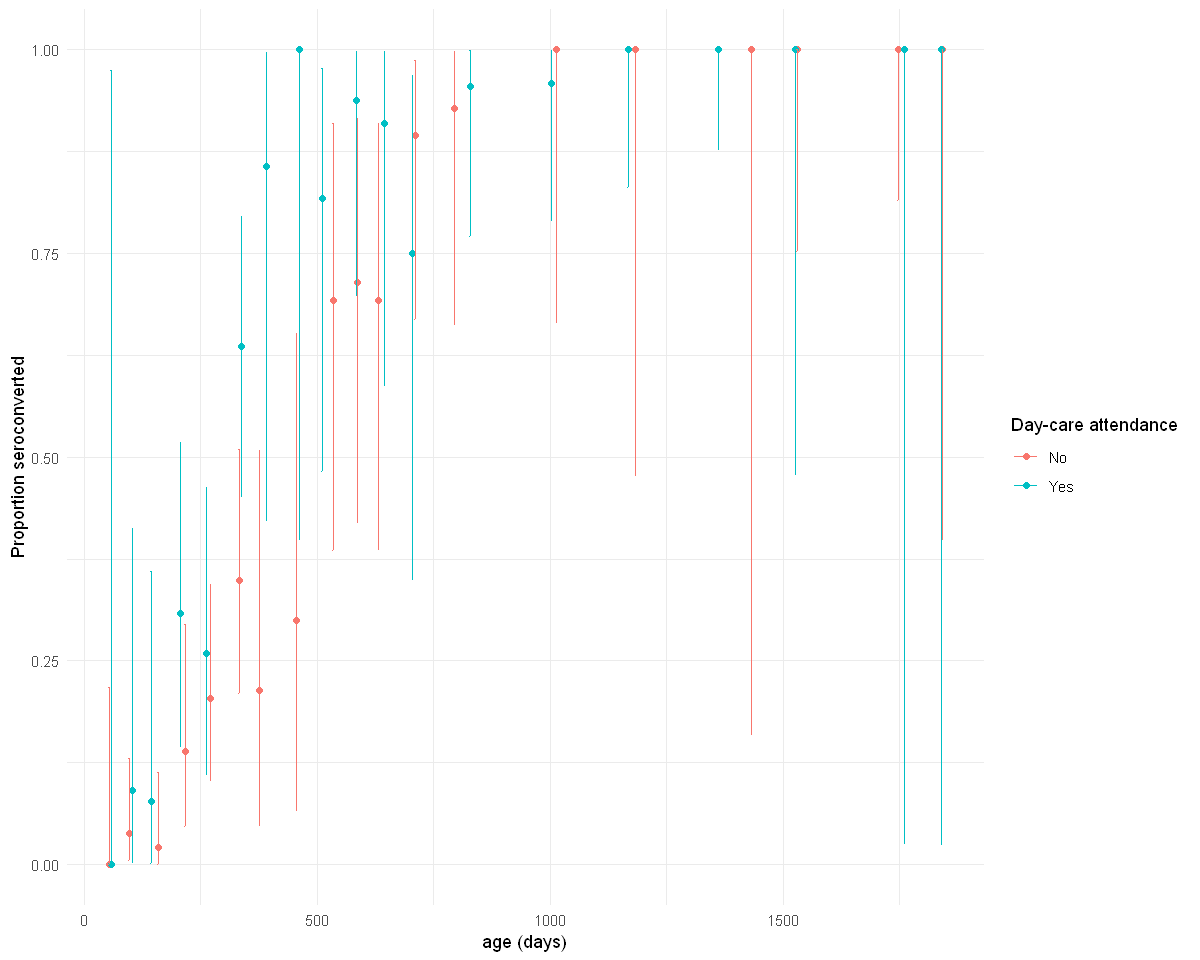

In [36]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(nusrey) +
  geom_point(aes(x=agemid, y=seroprev_mean, colour = factor(visitnursery_child))) +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95, colour = factor(visitnursery_child))) +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(colour = "Day-care attendance")


In [32]:
day_care <- subset(nusrey, visitnursery_child == "Yes")
no_day_care <- subset (nusrey, visitnursery_child == "No")

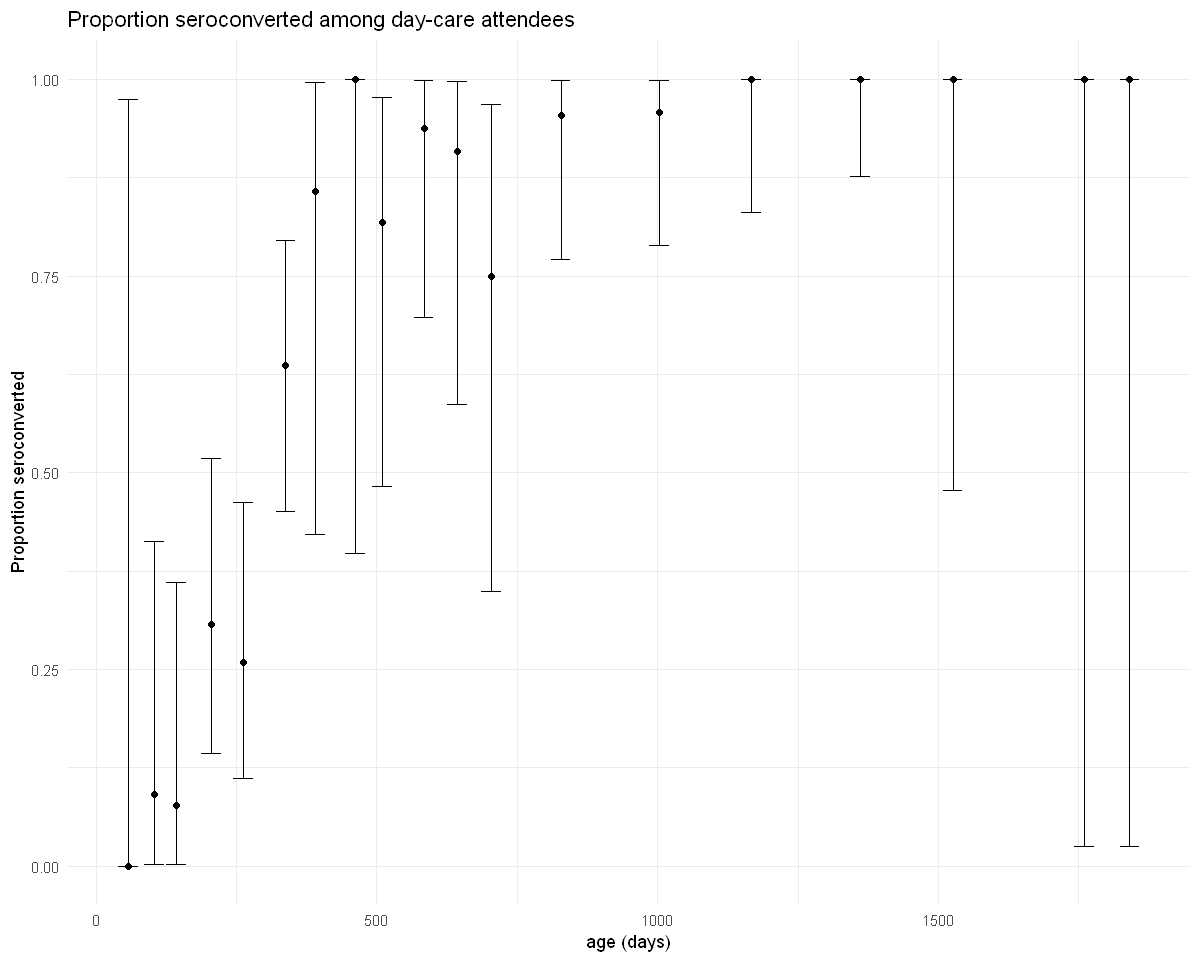

In [37]:
ggplot(day_care) +
  geom_point(aes(x=agemid, y=seroprev_mean)) +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(title = "Proportion seroconverted among day-care attendees")

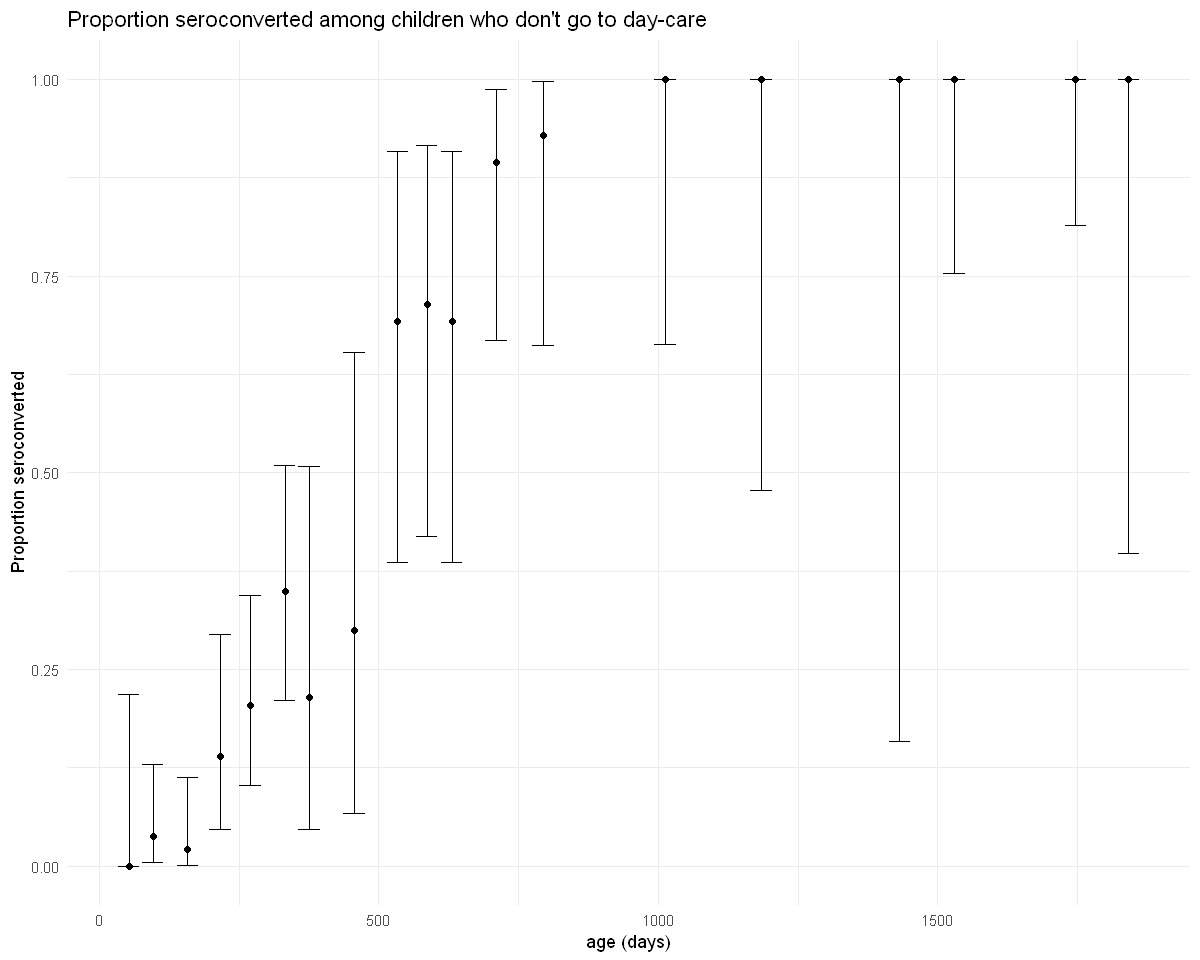

In [38]:
ggplot(no_day_care) +
  geom_point(aes(x=agemid, y=seroprev_mean)) +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(title = "Proportion seroconverted among children who don't go to day-care")